In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import precision_score, recall_score, classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from pretty_confusion_matrix import pp_matrix_from_data

# Models
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras import Sequential, Model
from tensorflow.keras.utils import plot_model

### Load Data

In [2]:
df = pd.read_excel('features.xlsx')
df.head()

,Unnamed: 0,r,rw,rx,rwc,rwx,rwxc,label,category,sample
0,0,367,307,117,84,70,0,B,Utilities,B_Utilities_7zip.json
1,1,107,96,43,31,5,0,B,Utilities,B_Utilities_7zip.json
2,2,62,59,18,21,49,0,B,Utilities,B_Utilities_AxCrypt.json
3,3,132,120,52,40,6,0,B,Filezilla.json,B_Filezilla.json
4,4,165,166,69,35,6,0,B,Spotify.json,B_Spotify.json


### EDA

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 937 entries, 0 to 936
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  937 non-null    int64 
 1   r           937 non-null    int64 
 2   rw          937 non-null    int64 
 3   rx          937 non-null    int64 
 4   rwc         937 non-null    int64 
 5   rwx         937 non-null    int64 
 6   rwxc        937 non-null    int64 
 7   label       937 non-null    object
 8   category    937 non-null    object
 9   sample      937 non-null    object
dtypes: int64(7), object(3)
memory usage: 73.3+ KB


In [6]:
# check mising values
df.isnull().sum()

Unnamed: 0    0
r             0
rw            0
rx            0
rwc           0
rwx           0
rwxc          0
label         0
category      0
sample        0
dtype: int64

In [5]:
df['label'].unique()

array(['B', 'M'], dtype=object)

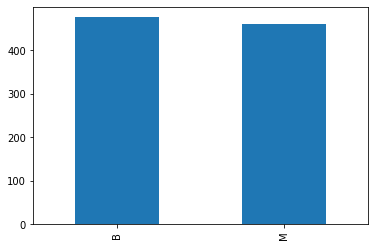

In [6]:
(df['label'].value_counts()).plot(kind='bar');

In [7]:
# Map lables to numbers
df['label'] = df['label'].map({'B':0, 'M':1})

In [8]:
df['label'].value_counts()

0    476
1    461
Name: label, dtype: int64

In [9]:
df.head()

,Unnamed: 0,r,rw,rx,rwc,rwx,rwxc,label,category,sample
0,0,367,307,117,84,70,0,0,Utilities,B_Utilities_7zip.json
1,1,107,96,43,31,5,0,0,Utilities,B_Utilities_7zip.json
2,2,62,59,18,21,49,0,0,Utilities,B_Utilities_AxCrypt.json
3,3,132,120,52,40,6,0,0,Filezilla.json,B_Filezilla.json
4,4,165,166,69,35,6,0,0,Spotify.json,B_Spotify.json


In [10]:
df.drop(['Unnamed: 0', 'category', 'sample'], inplace=True, axis=1)

In [11]:
df.head()

,r,rw,rx,rwc,rwx,rwxc,label
0,367,307,117,84,70,0,0
1,107,96,43,31,5,0,0
2,62,59,18,21,49,0,0
3,132,120,52,40,6,0,0
4,165,166,69,35,6,0,0


In [12]:
features = df.iloc[:, :-1].values
labels = df['label'].values

### Split Dataset to training and testing set

In [13]:
x_train, x_test, y_train, y_test  = train_test_split(features, labels, test_size=0.2, random_state=42, stratify=labels)

### Modelling 

In [14]:
def model_peformance(model_name, y_test, y_pred):
    
    overall_accuracy = round(accuracy_score(y_test, y_pred), 2)
    
    # Precision for Benign class
    B_precision = round(precision_score(y_test==0, y_pred==0), 2)
    M_precision = round(precision_score(y_test==1, y_pred==1), 2)
    
    # recall for benign class
    B_recall = round(recall_score(y_test==0, y_pred==0), 2)
    M_recall = round(recall_score(y_test==1, y_pred==1), 2)
    
    B_f1_score = round(f1_score(y_test==0, y_pred==0), 2)
    M_f1_score = round(f1_score(y_test==1, y_pred==1), 2)
    
    # Caluclate TN, FP, BFN, BTP for Benign class
    BTN, BFP, BFN, BTP = confusion_matrix(y_test==0, y_pred==0).ravel()
    
    # Caluclate TN, FP, BFN, BTP for Malicious class
    MTN, MFP, MFN, MTP = confusion_matrix(y_test==1, y_pred==1).ravel()
    
    pp_matrix_from_data(y_test, y_pred, columns=['Benign', 'Malicious'])
    
    print(f"Performance table for {model_name} classifier!")
    table = pd.DataFrame({'Label':['Benign', 'Malicious'],
              'TP':[BTP, MTP],
              'FP':[BFP, MFP],
              'TN':[BTN, MTN],
              'FN':[BFN, MFN],
              'Precision':[B_precision, M_precision],
              'Recall':[B_recall, M_recall],
              'F1 Score':[B_f1_score, M_f1_score],
              'Overall Accuracy': overall_accuracy
             })
     
    return table

### Decision Tree

In [15]:
decision_tree = DecisionTreeClassifier()

# Fit on training data
decision_tree.fit(x_train, y_train)
dec_tree_pred = decision_tree.predict(x_test)

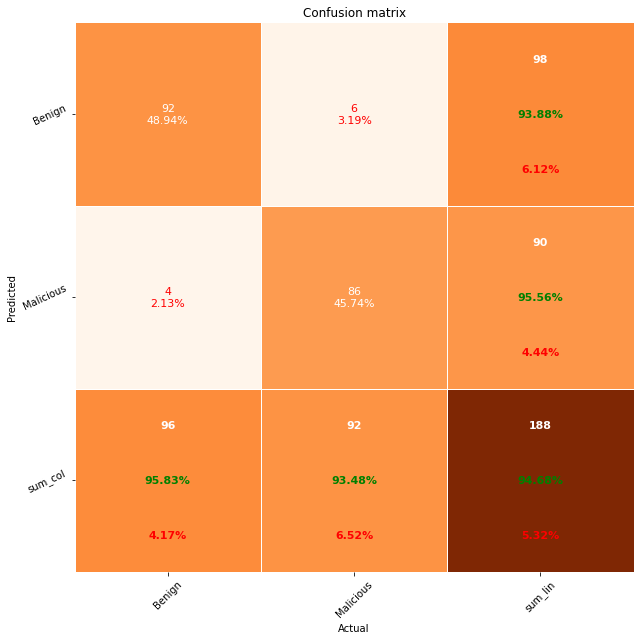

Performance table for Decision Tree classifier!


,Label,TP,FP,TN,FN,Precision,Recall,F1 Score,Overall Accuracy
0,Benign,92,6,86,4,0.94,0.96,0.95,0.95
1,Malicious,86,4,92,6,0.96,0.93,0.95,0.95


In [16]:
# Evaluate Perfomance
model_peformance('Decision Tree',y_test, dec_tree_pred)

### Random Forest

In [17]:
Random_forest = RandomForestClassifier()
Random_forest.fit(x_train, y_train)
# Fit on Data
Random_forest_pred = Random_forest.predict(x_test)

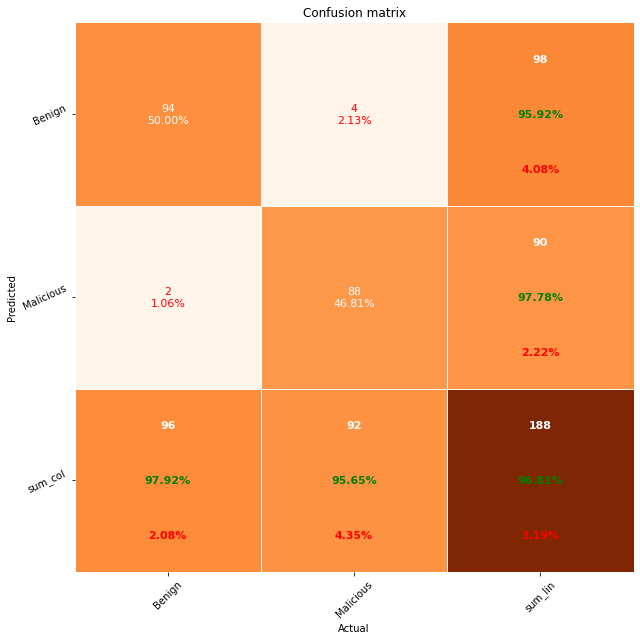

Performance table for Random Forest classifier!


,Label,TP,FP,TN,FN,Precision,Recall,F1 Score,Overall Accuracy
0,Benign,94,4,88,2,0.96,0.98,0.97,0.97
1,Malicious,88,2,94,4,0.98,0.96,0.97,0.97


In [18]:
model_peformance("Random Forest", y_test, Random_forest_pred)

### XGboost

In [19]:
xgb = XGBClassifier(use_label_encoder=False)
xgb.fit(x_train, y_train)
xgb_pred = xgb.predict(x_test)

[12:24:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


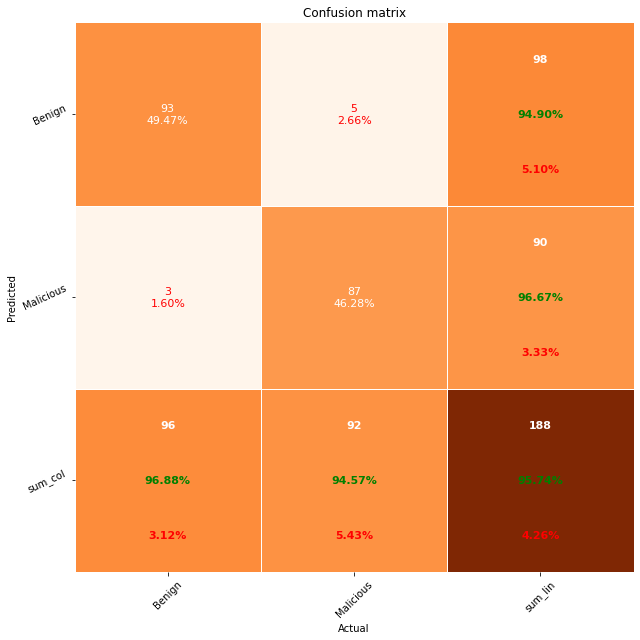

Performance table for XGBoost classifier!


,Label,TP,FP,TN,FN,Precision,Recall,F1 Score,Overall Accuracy
0,Benign,93,5,87,3,0.95,0.97,0.96,0.96
1,Malicious,87,3,93,5,0.97,0.95,0.96,0.96


In [20]:
model_peformance("XGBoost", y_test, xgb_pred)

In [21]:
gradient_boost = GradientBoostingClassifier()

gradient_boost.fit(x_train, y_train)

gradient_pred = gradient_boost.predict(x_test)

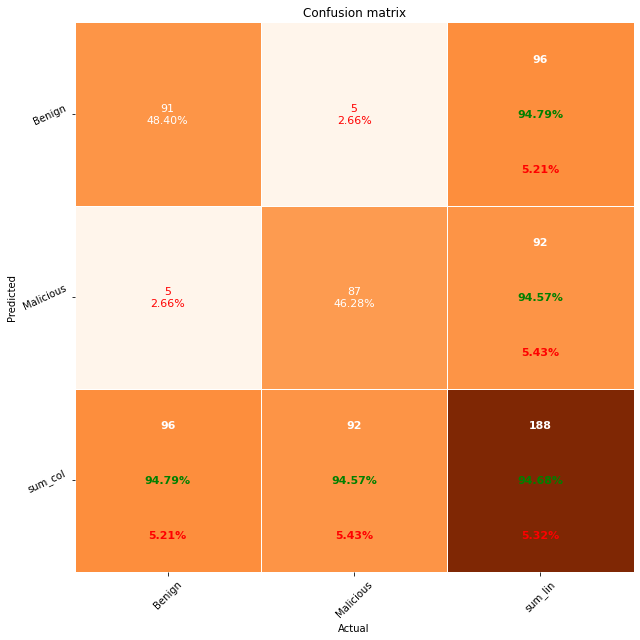

Performance table for Gradient Boosting classifier!


,Label,TP,FP,TN,FN,Precision,Recall,F1 Score,Overall Accuracy
0,Benign,91,5,87,5,0.95,0.95,0.95,0.95
1,Malicious,87,5,91,5,0.95,0.95,0.95,0.95


In [22]:
# Evaluate model performance
model_peformance('Gradient Boosting', y_test, gradient_pred)

### Deep Learning Approach

In [23]:
model = Sequential([
    Dense(64, activation='relu', input_shape=(x_train.shape[1], )),
    Dense(64, activation='relu'),
    Dense(512, activation='relu'),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
    
])

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                448       
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 512)               33280     
                                                                 
 dense_3 (Dense)             (None, 512)               262656    
                                                                 
 dense_4 (Dense)             (None, 1)                 513       
                                                                 
Total params: 301,057
Trainable params: 301,057
Non-trainable params: 0
_________________________________________________________________


In [26]:
plot_model(model, 'modl.png', show_shapes=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [27]:
x_train = x_train.astype("float32")
x_test = x_test.astype("float32")

In [28]:
model.compile('adam', loss='binary_crossentropy', metrics = ['accuracy'])

In [29]:
model.fit(x_train, y_train, validation_data=(x_test, y_test),
         batch_size = 8, verbose=1, epochs=30)

Epoch 1/30
94/94 [==============================] - 3s 17ms/step - loss: 1.4208 - accuracy: 0.6435 - val_loss: 0.6819 - val_accuracy: 0.8457
Epoch 2/30
94/94 [==============================] - 1s 13ms/step - loss: 0.5565 - accuracy: 0.7263 - val_loss: 0.6505 - val_accuracy: 0.6330
Epoch 3/30
94/94 [==============================] - 1s 13ms/step - loss: 0.7323 - accuracy: 0.7103 - val_loss: 0.3920 - val_accuracy: 0.8351
Epoch 4/30
94/94 [==============================] - 1s 13ms/step - loss: 0.4646 - accuracy: 0.7864 - val_loss: 0.3674 - val_accuracy: 0.8191
Epoch 5/30
94/94 [==============================] - 1s 13ms/step - loss: 0.4212 - accuracy: 0.7957 - val_loss: 0.4273 - val_accuracy: 0.7287
Epoch 6/30
94/94 [==============================] - 1s 13ms/step - loss: 0.4121 - accuracy: 0.8024 - val_loss: 0.3777 - val_accuracy: 0.8457
Epoch 7/30
94/94 [==============================] - 1s 15ms/step - loss: 0.4074 - accuracy: 0.8171 - val_loss: 0.3293 - val_accuracy: 0.8564
Epoch 8/30
94

In [30]:
ANN_preds = model.predict(x_test)
ANN_preds = np.where(ANN_preds > 0.5, 1, 0)

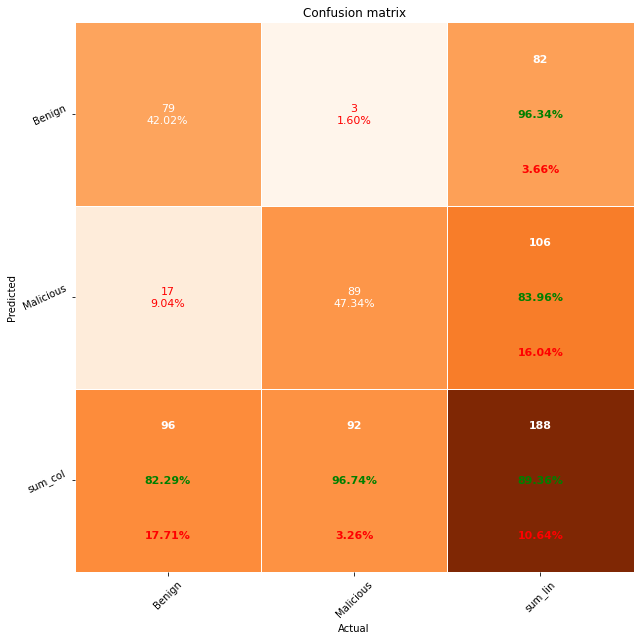

Performance table for ANN classifier!


,Label,TP,FP,TN,FN,Precision,Recall,F1 Score,Overall Accuracy
0,Benign,79,3,89,17,0.96,0.82,0.89,0.89
1,Malicious,89,17,79,3,0.84,0.97,0.90,0.89


In [31]:
model_peformance('ANN', y_test, ANN_preds)